In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [ ]:
path = '/content/drive/MyDrive/정보분석/제출파일/Data/'
df = pd.read_csv(path + 'final_df.csv')

In [ ]:
df.head()

,date,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,dust,uv_index,temperature_2m (°C),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),direction,region,AQI
0,2022-08-04 00:00:00,128.0,4.9,1.0,95.0,0.09,1.0,34.2,12.6,177,30.2,21.6,0.271,0.299,SE,USA,24.583333
1,2022-08-04 01:00:00,131.0,5.6,1.1,94.0,0.10,1.0,32.2,10.7,166,30.0,21.6,0.271,0.299,SE,USA,26.666667
2,2022-08-04 02:00:00,136.0,6.4,1.4,92.0,0.11,0.0,30.9,10.0,159,29.7,21.6,0.270,0.299,SE,USA,28.333333
3,2022-08-04 03:00:00,142.0,7.6,1.5,88.0,0.13,0.0,30.4,11.5,166,29.4,21.6,0.270,0.299,SE,USA,29.583333
4,2022-08-04 04:00:00,145.0,8.3,1.5,84.0,0.16,0.0,29.7,8.5,168,29.3,21.6,0.270,0.299,SE,USA,32.083333


In [ ]:
usa = df[df['region'] == 'USA']
china = df[df['region'] == 'China']
europa = df[df['region'] == 'Europa']

In [ ]:
usa_ = usa.drop(columns = ['date' , 'region'] , axis = 1)
china_ = china.drop(columns = ['date' , 'region'] , axis = 1)
europa_ = europa.drop(columns = ['date' , 'region'] , axis = 1)

In [ ]:
usa_y = usa_[['AQI']] ; usa_.drop(columns = ['AQI'] , axis = 1 , inplace = True)
china_y = china_[['AQI']] ; china_.drop(columns = ['AQI'] , axis = 1 , inplace = True)
europa_y = europa_[['AQI']] ; europa_.drop(columns = ['AQI'] , axis = 1 , inplace = True)

### 모델링

In [ ]:
usa_dummy = pd.get_dummies(usa_['direction'])
usa_dummy = usa_dummy.apply(lambda x : x.astype('int'))
usa_ = pd.concat([usa_ , usa_dummy] , axis = 1)
usa_.drop(columns = ['direction'] , axis = 1 , inplace = True)

In [ ]:
china_dummy = pd.get_dummies(china_['direction'])
china_dummy = china_dummy.apply(lambda x : x.astype('int'))
china_ = pd.concat([china_ , china_dummy] , axis = 1)
china_.drop(columns = ['direction'] , axis = 1 , inplace = True)

In [ ]:
europa_dummy = pd.get_dummies(europa_['direction'])
europa_dummy = europa_dummy.apply(lambda x : x.astype('int'))
europa_ = pd.concat([europa_ , europa_dummy] , axis = 1)
europa_.drop(columns = ['direction'] , axis = 1 , inplace = True)

In [ ]:
# USA

scaler = MinMaxScaler()

cols = ['carbon_monoxide' , 'nitrogen_dioxide' , 'sulphur_dioxide' ,
        'ozone' , 'dust' , 'temperature_2m (°C)' , 'wind_speed_10m (km/h)' ,
        'wind_direction_10m (°)' , 'soil_temperature_0_to_100cm (°C)' ,
        'soil_temperature_100_to_255cm (°C)' , 'soil_moisture_0_to_100cm (m³/m³)' ,
        'soil_moisture_100_to_255cm (m³/m³)']

scaled_x = scaler.fit_transform(usa_[cols])
scaled_x = pd.DataFrame(scaled_x , columns = cols)

scaled_y = scaler.fit_transform(usa_y)

usa_[cols] = scaled_x
usa_y = scaled_y

In [ ]:
# usa_.drop(columns = ['dust'] , axis = 1 , inplace = True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor , ExtraTreesRegressor , GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split , KFold

trainX , testX , trainY , testY = train_test_split(usa_ , usa_y , test_size = 0.3 , random_state = 42)
kfold = KFold(n_splits = 10)

random_state = 42
regressors = []
regressors.append(RandomForestRegressor(random_state = random_state))
regressors.append(AdaBoostRegressor(random_state = random_state))
regressors.append(ExtraTreesRegressor(random_state = random_state))
regressors.append(GradientBoostingRegressor(random_state = random_state))
regressors.append(DecisionTreeRegressor(random_state = random_state))
regressors.append(MLPRegressor(random_state = random_state))
regressors.append(KNeighborsRegressor())
regressors.append(LinearRegression())
regressors.append(SVR())

cv_results = []
for regressor in regressors:
    cv_results.append(cross_val_score(regressor , trainX , trainY , scoring = 'r2' , cv = kfold , n_jobs = 4))

cv_mean = [] ; cv_std = []
for cr in cv_results:
    cv_mean.append(cr.mean()) ; cv_std.append(cr.std())

cv_res = pd.DataFrame({
    'CrossValMeans' : cv_mean ,
    'CrossValStd' : cv_std ,
    'Algorithms' : [
        'RF' , 'Ada' , 'Extra' , 'GB' , 'DT' ,
        'MLP' , 'KN' , 'LR' , 'SVR'
    ]
})

cv_res

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


,CrossValMeans,CrossValStd,Algorithms
0,0.864555,0.009477,RF
1,0.460964,0.030981,Ada
2,0.897368,0.005833,Extra
3,0.699276,0.015112,GB
4,0.683722,0.026695,DT
5,0.648808,0.026191,MLP
6,0.779619,0.015994,KN
7,0.560864,0.023311,LR
8,0.675138,0.019100,SVR


<ipython-input-37-e4421fb1faf4>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x = 'CrossValMeans' , y = 'Algorithms' , data = cv_res , palette = 'Set3' , orient = 'h')


Text(0.5, 1.0, 'Cross validation scores')

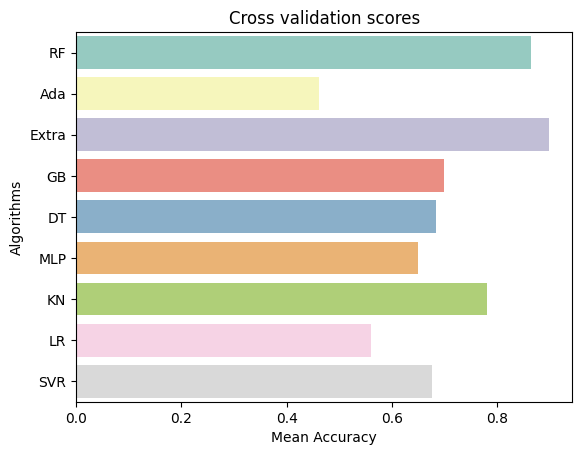

In [ ]:
g = sns.barplot(x = 'CrossValMeans' , y = 'Algorithms' , data = cv_res , palette = 'Set3' , orient = 'h')
plt.xlabel('Mean Accuracy')
plt.title('Cross validation scores')

In [ ]:
from sklearn.model_selection import GridSearchCV

ExtC = ExtraTreesRegressor()

ex_param_grid = {
    'max_depth' : [3 , 5 , 7] ,
    'max_features' : [1 , 3 , 10] ,
    'min_samples_split' : [2 , 3 , 10] ,
    'min_samples_leaf' : [1 , 3 , 10] ,
    'bootstrap' : [False] ,
    'n_estimators' : [100 , 300]
}

gsExtC = GridSearchCV(ExtC , param_grid = ex_param_grid , cv = kfold , scoring = 'r2' ,
                      n_jobs = 4 , verbose = 1)

gsExtC.fit(trainX , trainY)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
from sklearn.model_selection import learning_curve

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


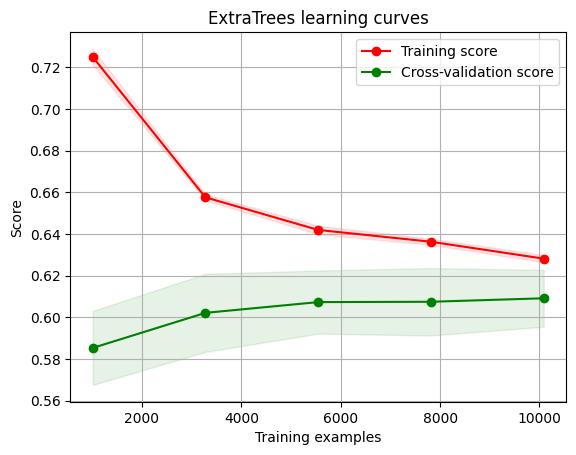

In [ ]:
def plot_learning_curve(estimator , title , X , y , ylim = None , cv = None ,
                        n_jobs = -1 , train_sizes = np.linspace(.1 , 1.0 , 5)):

                        plt.figure()
                        plt.title(title)

                        if ylim is not None:
                            plt.ylim(*ylim)

                        plt.xlabel('Training examples')
                        plt.ylabel('Score')

                        train_sizes , train_scores , test_scores = learning_curve(
                            estimator , X , y , cv = cv , n_jobs = n_jobs , train_sizes = train_sizes
                        )
                        train_scores_mean = np.mean(train_scores , axis = 1)
                        train_scores_std = np.std(train_scores , axis = 1)
                        test_scores_mean = np.mean(test_scores , axis = 1)
                        test_scores_std = np.std(test_scores , axis = 1)

                        plt.grid()

                        plt.fill_between(train_sizes , train_scores_mean - train_scores_std ,
                                         train_scores_mean + train_scores_std , alpha = 0.1 ,
                                         color = 'r')
                        plt.fill_between(train_sizes , test_scores_mean - test_scores_std ,
                                         test_scores_mean + test_scores_std , alpha = 0.1 ,
                                         color = 'g')

                        plt.plot(train_sizes , train_scores_mean , 'o-' , color = 'r' ,
                                 label = 'Training score')

                        plt.plot(train_sizes , test_scores_mean , 'o-' , color = 'g' ,
                                 label = 'Cross-validation score')

                        plt.legend(loc = 'best')

                        return plt

g = plot_learning_curve(gsExtC.best_estimator_ , 'ExtraTrees learning curves' , trainX , trainY , cv = kfold)

In [ ]:
model = ExtC_best

model.fit(trainX , trainY)

<ipython-input-47-78bc52fe2dcf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(trainX , trainY)


ExtraTreesRegressor(max_depth=7, max_features=10, n_estimators=300)

In [ ]:
model.score(trainX , trainY)

0.6274676176959909

In [ ]:
model.score(testX , testY)

0.6158200938439867

In [ ]:
fi = model.feature_importances_

data = pd.Series(fi , index = usa_.columns)

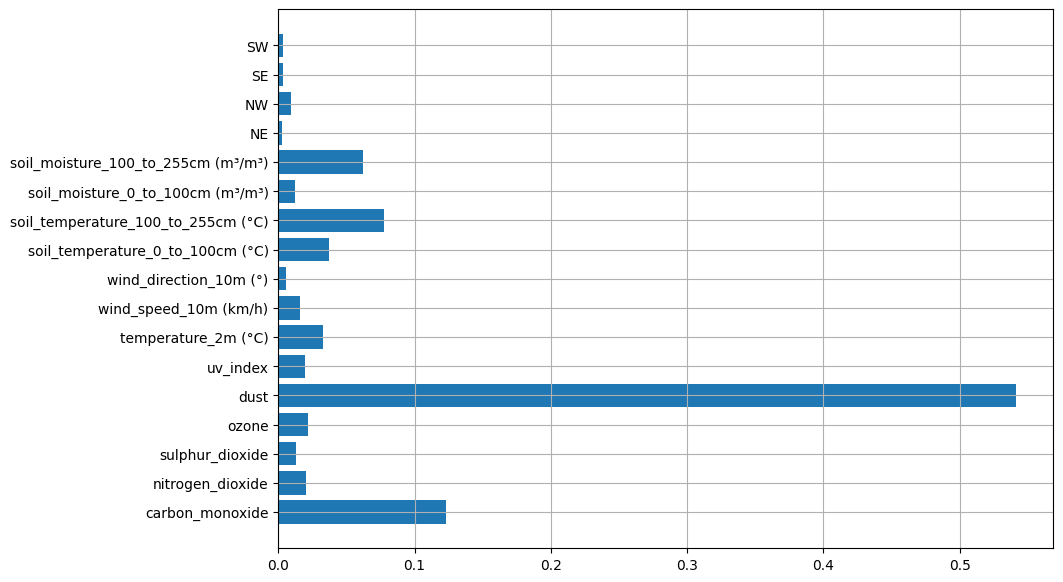

In [ ]:
plt.figure(figsize = (10 , 7))
plt.barh(data.index , data.values)
plt.grid()
plt.show()

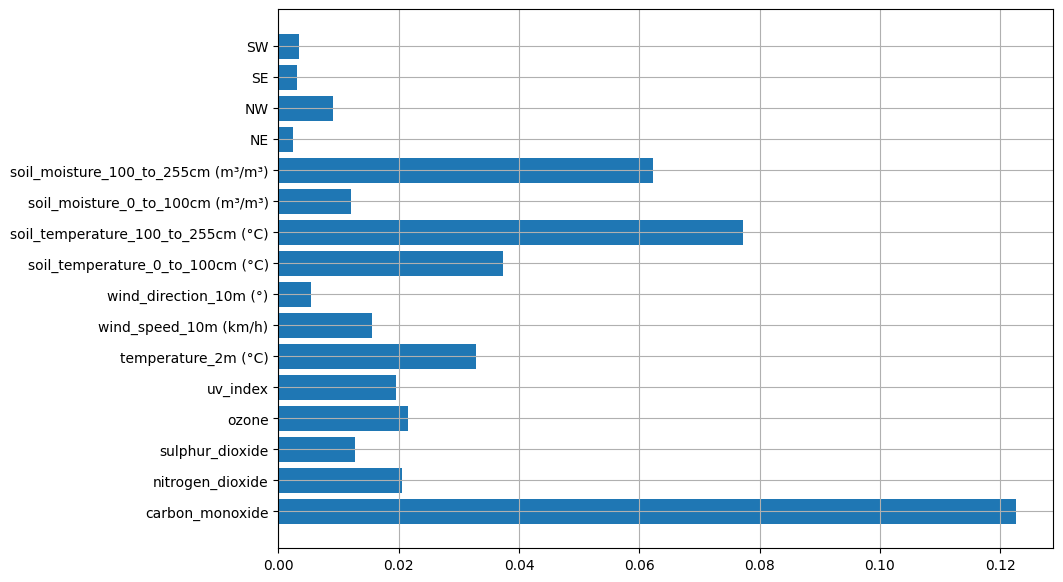

In [ ]:
data_ = data.drop(['dust'])

plt.figure(figsize = (10 , 7))
plt.barh(data_.index , data_.values)
plt.grid()
plt.show()

In [ ]:
# USA

scaler = MinMaxScaler()

cols = ['carbon_monoxide' , 'nitrogen_dioxide' , 'sulphur_dioxide' ,
        'ozone' , 'dust' , 'temperature_2m (°C)' , 'wind_speed_10m (km/h)' ,
        'wind_direction_10m (°)' , 'soil_temperature_0_to_100cm (°C)' ,
        'soil_temperature_100_to_255cm (°C)' , 'soil_moisture_0_to_100cm (m³/m³)' ,
        'soil_moisture_100_to_255cm (m³/m³)']

scaled_x = scaler.fit_transform(china_[cols])
scaled_x = pd.DataFrame(scaled_x , columns = cols)

scaled_y = scaler.fit_transform(china_y)

china_[cols] = scaled_x
china_y = scaled_y

In [ ]:
# usa_.drop(columns = ['dust'] , axis = 1 , inplace = True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor , ExtraTreesRegressor , GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split , KFold

trainX , testX , trainY , testY = train_test_split(china_ , china_y , test_size = 0.3 , random_state = 42)
kfold = KFold(n_splits = 10)

random_state = 42
regressors = []
regressors.append(RandomForestRegressor(random_state = random_state))
regressors.append(AdaBoostRegressor(random_state = random_state))
regressors.append(ExtraTreesRegressor(random_state = random_state))
regressors.append(GradientBoostingRegressor(random_state = random_state))
regressors.append(DecisionTreeRegressor(random_state = random_state))
regressors.append(MLPRegressor(random_state = random_state))
regressors.append(KNeighborsRegressor())
regressors.append(LinearRegression())
regressors.append(SVR())

cv_results = []
for regressor in regressors:
    cv_results.append(cross_val_score(regressor , trainX , trainY , scoring = 'r2' , cv = kfold , n_jobs = 4))

cv_mean = [] ; cv_std = []
for cr in cv_results:
    cv_mean.append(cr.mean()) ; cv_std.append(cr.std())

cv_res = pd.DataFrame({
    'CrossValMeans' : cv_mean ,
    'CrossValStd' : cv_std ,
    'Algorithms' : [
        'RF' , 'Ada' , 'Extra' , 'GB' , 'DT' ,
        'MLP' , 'KN' , 'LR' , 'SVR'
    ]
})

cv_res

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 921, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
g = sns.barplot(x = 'CrossValMeans' , y = 'Algorithms' , data = cv_res , palette = 'Set3' , orient = 'h')
plt.xlabel('Mean Accuracy')
plt.title('Cross validation scores')

In [ ]:
from sklearn.model_selection import GridSearchCV

ExtC = ExtraTreesRegressor()

ex_param_grid = {
    'max_depth' : [3 , 5 , 7] ,
    'max_features' : [1 , 3 , 10] ,
    'min_samples_split' : [2 , 3 , 10] ,
    'min_samples_leaf' : [1 , 3 , 10] ,
    'bootstrap' : [False] ,
    'n_estimators' : [100 , 300]
}

gsExtC = GridSearchCV(ExtC , param_grid = ex_param_grid , cv = kfold , scoring = 'r2' ,
                      n_jobs = 4 , verbose = 1)

gsExtC.fit(trainX , trainY)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
from sklearn.model_selection import learning_curve

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


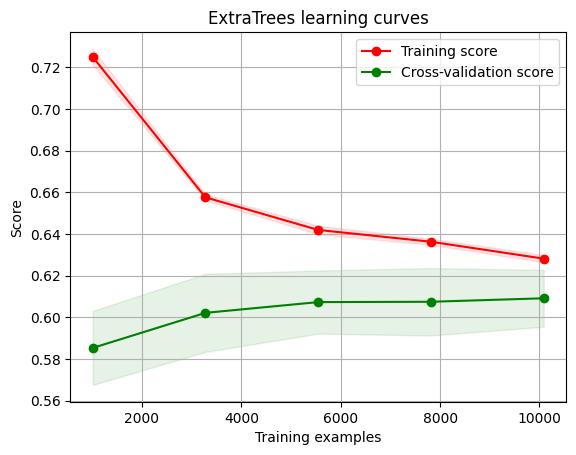

In [ ]:
def plot_learning_curve(estimator , title , X , y , ylim = None , cv = None ,
                        n_jobs = -1 , train_sizes = np.linspace(.1 , 1.0 , 5)):

                        plt.figure()
                        plt.title(title)

                        if ylim is not None:
                            plt.ylim(*ylim)

                        plt.xlabel('Training examples')
                        plt.ylabel('Score')

                        train_sizes , train_scores , test_scores = learning_curve(
                            estimator , X , y , cv = cv , n_jobs = n_jobs , train_sizes = train_sizes
                        )
                        train_scores_mean = np.mean(train_scores , axis = 1)
                        train_scores_std = np.std(train_scores , axis = 1)
                        test_scores_mean = np.mean(test_scores , axis = 1)
                        test_scores_std = np.std(test_scores , axis = 1)

                        plt.grid()

                        plt.fill_between(train_sizes , train_scores_mean - train_scores_std ,
                                         train_scores_mean + train_scores_std , alpha = 0.1 ,
                                         color = 'r')
                        plt.fill_between(train_sizes , test_scores_mean - test_scores_std ,
                                         test_scores_mean + test_scores_std , alpha = 0.1 ,
                                         color = 'g')

                        plt.plot(train_sizes , train_scores_mean , 'o-' , color = 'r' ,
                                 label = 'Training score')

                        plt.plot(train_sizes , test_scores_mean , 'o-' , color = 'g' ,
                                 label = 'Cross-validation score')

                        plt.legend(loc = 'best')

                        return plt

g = plot_learning_curve(gsExtC.best_estimator_ , 'ExtraTrees learning curves' , trainX , trainY , cv = kfold)

In [ ]:
model = ExtC_best

model.fit(trainX , trainY)

<ipython-input-47-78bc52fe2dcf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(trainX , trainY)


ExtraTreesRegressor(max_depth=7, max_features=10, n_estimators=300)

In [ ]:
model.score(trainX , trainY)

0.6274676176959909

In [ ]:
model.score(testX , testY)

0.6158200938439867

In [ ]:
fi = model.feature_importances_

data = pd.Series(fi , index = usa_.columns)

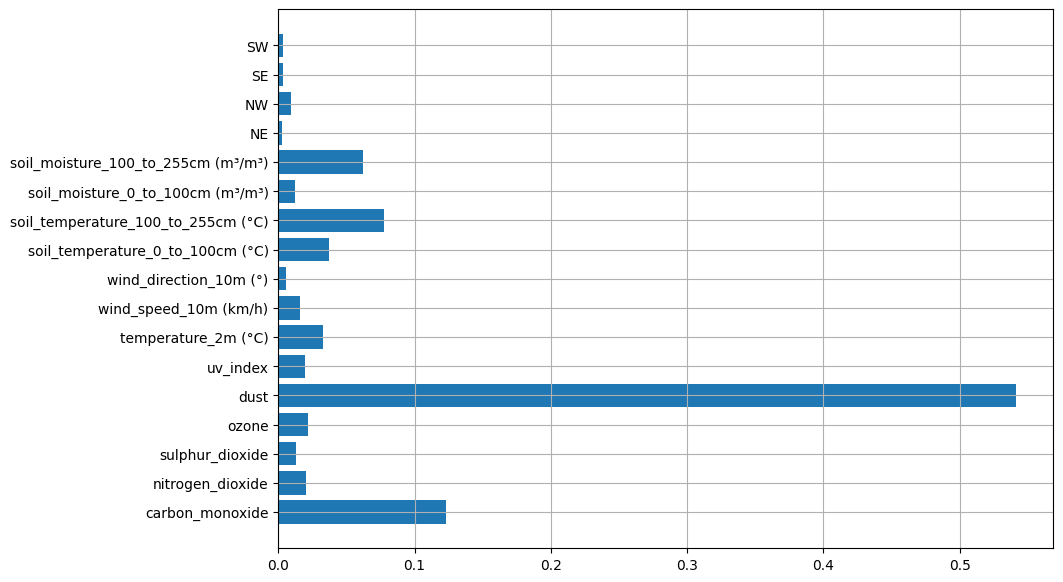

In [ ]:
plt.figure(figsize = (10 , 7))
plt.barh(data.index , data.values)
plt.grid()
plt.show()

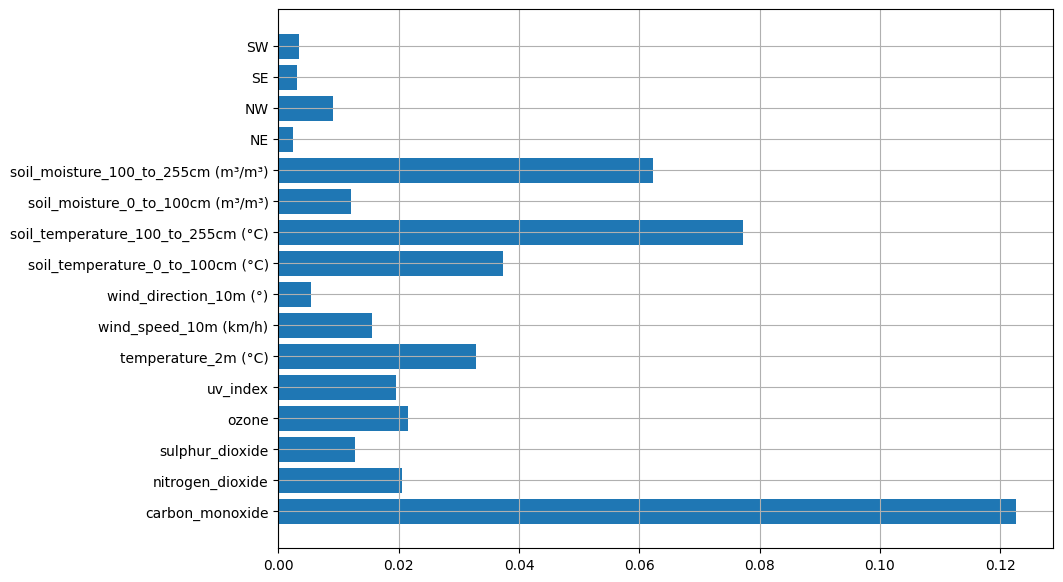

In [ ]:
data_ = data.drop(['dust'])

plt.figure(figsize = (10 , 7))
plt.barh(data_.index , data_.values)
plt.grid()
plt.show()